In [1]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import v_measure_score
import re
from pysr import PySRRegressor
import sympy
from collections import Counter


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# set wd
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/iclust_paper/'

In [3]:
# get input traj
noises = ['0.0', '0.04', '0.08', '0.12', '0.16', '0.2']
reps = [str(x) for x in range(10)]

noise_to_rep = {}

for n in noises:
    noise_to_rep[n] = {}
    for r in reps:
        df_traj = pd.read_csv(path + 'inputs/loclust_sims/' + n + 'noise.exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.200reps.' + r + '.tsv', sep='\t', index_col=0)

        # grab first 4 instances per traj instead of 200
        df_traj = df_traj.groupby('func').head(4)

        # convert input traj file to one singular df 
        # use X values as the index
        X = df_traj.X.values
        X = [[float(i) for i in x.split(',')] for x in X]
        X = [item for sublist in X for item in sublist]
        X = sorted(set(X))
        
        # create df from dict
        input = {}
        input['t'] = X
        df_input = pd.DataFrame.from_dict(input)
        df_input = df_input.set_index('t')
        
        # iterate through each row column pair
        df_data = df_traj.loc[:,['X','Y']]
        for index in df_data.index:
            row = df_data.loc[index]
            X = [float(i) for i in row['X'].split(',')]
            Y = [float(i) for i in row['Y'].split(',')]
            new_df = pd.DataFrame({'t': X, index: Y})
            new_df = new_df.set_index('t')
            
            df_input = pd.concat([df_input, new_df], axis=1)
        
        df_input = df_input.reset_index()
        df_input.iloc[:,0:5].to_csv(path + 'inputs/iclust_loclust_sims/df_sim_test_' + n + '_' + r + '.tsv', sep='\t')
        df_input.to_csv(path + 'inputs/iclust_loclust_sims/df_sim_' + n + '_' + r + '.tsv', sep='\t')
        df_input.columns = df_input.columns.astype(str)
        noise_to_rep[n][r] = df_input

df_traj.head()

,X,Y,func,noise,original_trajectory
ID,,,,,
307259,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19","10.6997007997,6.98366939035,11.014612357,9.580...",norm,0.2,264000
307566,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19","17.1160511085,15.9467079771,18.2979644231,19.6...",norm,0.2,264000
307521,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19","-9.96959751341,-9.82405292537,-10.9954914071,-...",norm,0.2,264000
306593,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19","2.13646729095,5.72510583249,3.54819407662,5.43...",norm,0.2,264000
394587,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19","142.648383524,143.710018495,145.56799897,141.1...",sin,0.2,352000


In [5]:
# grab the vms results and compare what we have
df_vms = pd.read_csv(path + 'outputs/jobs86/v-measure_results_loclust.kml.kmlShape.traj.dtw.dbagak.pic.963.tsv', sep='\t', index_col=0)

# subset on 9 functions
df_vms = df_vms[df_vms['num_gen_functions'] == 9]

# parse results
for n in noises:
    for r in reps:
        # get cluster assignments
        fn = path + 'outputs/jobs87_pca_fix9/results/sim_' + n + '_' + r + '/iclust/nn_imgtocluster.pk'
        with open(fn, 'rb') as f:  # 'rb' stands for read binary
            unpacked_object = pickle.load(f)
        
        df = pd.DataFrame(list(unpacked_object.items()), columns=['image', 'cluster'])
        # fn is sims_5_0_0.396.jpg
        # map 0-3 to one cluster, etc
        df['image'] = df['image'].apply(lambda x: x.split('_')[3])
        df['image'] = df['image'].apply(lambda x: int((int(x)-1)/4))
        
        from sklearn.metrics.cluster import v_measure_score
        
        # Compute the V-measure score
        vms = v_measure_score(df.image.values, df.cluster.values)
        
        new_row = pd.DataFrame({'filename': [fn], 'tool': ['iclust'], 
                                'num_gen_functions': [9], 'rep_num': [r], 
                                'noise_level': [n], 'v_measure_score': [vms]})#, index=pd.Index([], name='filename'))
        df_vms = pd.concat([df_vms, new_row], axis=0)

df_vms.head()

,tool,num_gen_functions,rep_num,noise_level,v_measure_score,filename
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/9/exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.16noise.2/0.16noise.exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.200reps.2_loclust_fa.tsv,loclust_fa,9,2,0.16,0.810207,NaN
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/9/exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.16noise.2/0.16noise.exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.200reps.2_loclust_3pca.tsv,loclust_3pca,9,2,0.16,0.820900,NaN
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/9/exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.04noise.2/0.04noise.exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.200reps.2_loclust_3pca.tsv,loclust_3pca,9,2,0.04,0.856046,NaN
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/9/exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.04noise.2/0.04noise.exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.200reps.2_loclust_fa.tsv,loclust_fa,9,2,0.04,0.863549,NaN
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/9/exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.04noise.6/0.04noise.exponential-growth-hyperbolic-linear-norm-poly-scurve-sin-tan.200reps.6_loclust_3pca.tsv,loclust_3pca,9,6,0.04,0.847005,NaN


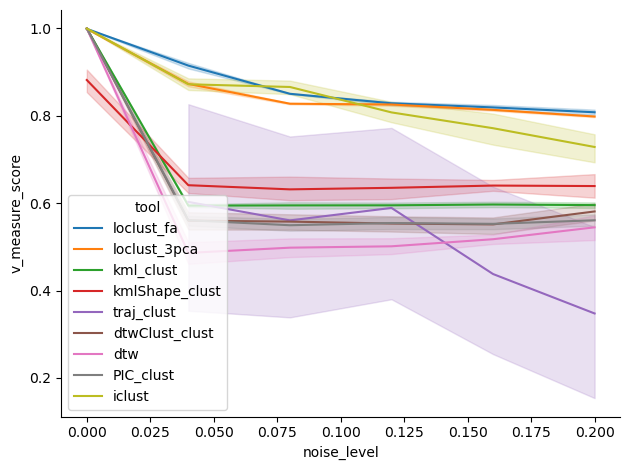

In [6]:
sns.lineplot(data=df_vms, x='noise_level', y='v_measure_score', hue='tool')
sns.despine()
plt.tight_layout()


In [7]:
# grab the vms results and compare what we have
df_vms = pd.read_csv(path + 'outputs/jobs86/v-measure_results_loclust.kml.kmlShape.traj.dtw.dbagak.pic.963.tsv', sep='\t', index_col=0)

# parse results
for n in ['0.0']:
    for r in ['0']:
        # get cluster assignments
        fn = path + 'outputs/jobs87/results/sim_' + n + '_' + r + '/iclust/nn_imgtocluster.pk'
        with open(fn, 'rb') as f:  # 'rb' stands for read binary
            unpacked_object = pickle.load(f)
        
        df = pd.DataFrame(list(unpacked_object.items()), columns=['image', 'cluster'])
        # fn is sims_5_0_0.396.jpg
        # map 0-3 to one cluster, etc
        df['image'] = df['image'].apply(lambda x: x.split('_')[3])
        df['image'] = df['image'].apply(lambda x: int(int(x)/4))
        
        from sklearn.metrics.cluster import v_measure_score
        
        # Compute the V-measure score
        vms = v_measure_score(df.image.values, df.cluster.values)
        
        new_row = pd.DataFrame({'filename': [fn], 'tool': ['iclust'], 
                                'num_gen_functions': [9], 'rep_num': [r], 
                                'noise_level': [n], 'v_measure_score': [vms]})#, index=pd.Index([], name='filename'))
        df_vms = pd.concat([df_vms, new_row], axis=0)

df_vms.head()

,tool,num_gen_functions,rep_num,noise_level,v_measure_score,filename
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/6/exponential-growth-linear-norm-poly-tan.16noise.5/0.16noise.exponential-growth-linear-norm-poly-tan.200reps.5_loclust_fa.tsv,loclust_fa,6,5,0.16,0.902575,NaN
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/6/exponential-growth-linear-norm-poly-tan.16noise.5/0.16noise.exponential-growth-linear-norm-poly-tan.200reps.5_loclust_3pca.tsv,loclust_3pca,6,5,0.16,0.782183,NaN
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/6/exponential-growth-linear-poly-sin-tan.12noise.5/0.12noise.exponential-growth-linear-poly-sin-tan.200reps.5_loclust_3pca.tsv,loclust_3pca,6,5,0.12,0.873067,NaN
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/6/exponential-growth-linear-poly-sin-tan.12noise.5/0.12noise.exponential-growth-linear-poly-sin-tan.200reps.5_loclust_fa.tsv,loclust_fa,6,5,0.12,0.875818,NaN
/sc/arion/projects/clemej05a/hilary/loclust_tool_comp/loclust_outputs/8/6/exponential-growth-linear-norm-poly-tan.12noise.0/0.12noise.exponential-growth-linear-norm-poly-tan.200reps.0_loclust_fa.tsv,loclust_fa,6,0,0.12,0.908538,NaN


In [9]:
# get metadata and test how good iclust was on sean data (spoiler, not very good)
meta = ['Diet'] 
dl = 'sean'
df_traj = pd.read_csv(path + 'inputs/Bacteroides_L6_loclust_k5_3pca.tsv', sep='\t')

# for each cluster # 
for j in ['jobs85']:
    print(j)
    
    # import results of iclust
    df_results = pd.read_csv(path + 'outputs/' + j + '/' + dl + '_0_0.0_iclust/nn_df_pca.tsv', sep='\t')
    
    # convert ID column from name of jpg image
    df_results['ID'] = df_results['Unnamed: 0'].apply(lambda x: x.split('_0_')[0])
    df_results['ID'] = df_results['ID'].apply(lambda x: x.split(dl + '_')[1])
    IDs = list(df_traj.index.values)
    df_results['ID'] = df_results['ID'].apply(lambda x: IDs[int(x)-1])
    df_results = df_results.set_index('ID')
    
    # merge with traj
    df_results = pd.concat([df_results, df_traj.loc[:,meta]],axis=1)
    
    # for each metadata variable
    for m in meta:
        print(m)
        # create contingency table
        contingency_table = pd.crosstab(index=df_results['group'], columns=df_results[m])
    
        # compute chi2
        chi2_stat, p_val, dof, expected = scipy.stats.chi2_contingency(contingency_table)
        
        # Print the results
        print("Observed frequencies:")
        print(contingency_table)
        print("Chi-squared statistic:", chi2_stat)
        print("P-value:", p_val)
        print("Degrees of freedom:", dof)
        print("Expected frequencies:")
        print(expected)

jobs85
Diet
Observed frequencies:
Diet       HC  HCEL  HPSY  LC
group                        
cluster 1   2     1     1   1
cluster 2   1     1     1   1
cluster 3   0     2     3   0
cluster 4   2     1     0   3
Chi-squared statistic: 9.333333333333334
P-value: 0.4070908354905886
Degrees of freedom: 9
Expected frequencies:
[[1.25 1.25 1.25 1.25]
 [1.   1.   1.   1.  ]
 [1.25 1.25 1.25 1.25]
 [1.5  1.5  1.5  1.5 ]]


In [10]:
op_to_k = {
    'x0': 'x',
    '+': 'o',
    '-': 'o',
    '**': '^',
    '*': '*',
    '/':  '/',
    '(': '(',
    ')': ')',
    'e+': '',
    'e-': '',
    'cos': 'trig',
    'sin': 'trig',
    'exp': 'e',
    'C': 'C'
}

def get_encoding(input_eq):
    test = simplify_n(input_eq, 5)
    test = str(test)
    
    # find all floats
    floats = re.findall(r"[-+]?(?:\d*\.*\d+)", test)
    floats = list(filter(('0').__ne__, floats))
    floats = sorted(floats, key=len, reverse=True)
    
    # replace floats with constant c
    for f in floats:
        test = test.replace(f,'C')
    
    # strip white space
    test = test.replace(' ','')
    
    # convert to mapping
    pattern = re.compile('|'.join(map(re.escape, op_to_k.keys())))
    
    # Define a function to replace matched substrings
    def replace_substring(match):
        return op_to_k[match.group(0)]
    
    # Apply replacement using regular expressions
    output_eq = pattern.sub(replace_substring, test)
    return(output_eq)



def test_encoding(input_eq):
    test = simplify_n(input_eq, 5)
    print(test)
    test = str(test)
    
    # find all floats
    floats = re.findall(r"[-+]?(?:\d*\.*\d+)", test)
    floats = list(filter(('0').__ne__, floats))
    floats = sorted(floats, key=len, reverse=True)
    
    # replace floats with constant c
    for f in floats:
        test = test.replace(f,'C')
    
    # strip white space
    test = test.replace(' ','')

    print(test)
    # convert to mapping
    pattern = re.compile('|'.join(map(re.escape, op_to_k.keys())))
    
    # Define a function to replace matched substrings
    def replace_substring(match):
        return op_to_k[match.group(0)]
    
    # Apply replacement using regular expressions
    output_eq = pattern.sub(replace_substring, test)
    return(output_eq)

def simplify_n(input_eq, n):
    if n > 1:
        return simplify_n(sympy.simplify(input_eq), n-1)
    else:
        return input_eq

print('Functions defined')

Functions defined


In [11]:
# define list to store models
t_encoded_models = {}
t_models = {}

n='0.0'
r='0'
nsim=1

df_input = noise_to_rep[n][r]

traj = list(df_input.columns)[1:]
for t in traj:
    models = []
    encoded_models = []
    for i in range(nsim):
        model = PySRRegressor(
            niterations=40,  # < Increase me for better results
            binary_operators=["+", "*"],
            unary_operators=[
                "cos",
                "exp",
                # "sin",
                "inv(x) = 1/x", # Custom operator (julia syntax)
            ],
            # denoise=True,
            extra_sympy_mappings={"inv": lambda x: 1 / x},
            temp_equation_file=True, # to delete temp files
            # ^ Define operator for SymPy as well
            # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
            elementwise_loss="L1DistLoss()",
            # ^ Custom loss function (julia syntax)
        )
        # This will set up the model for 40 iterations of the search code, which contains hundreds of thousands of mutations and equation evaluations.
        
        # Let's train this model on our dataset:
        X = df_input['t'].values.reshape(-1, 1)
        y = df_input.loc[:,t]
        model.fit(X, y)
        # Internally, this launches a Julia process which will do a multithreaded search for equations to fit the dataset.
        # Equations will be printed during training, and once you are satisfied, you may quit early by hitting 'q' and then <enter>.
        # After the model has been fit, you can run model.predict(X) to see the predictions on a given dataset using the automatically-selected expression, or, for example, model.predict(X, 3) to see the predictions of the 3rd equation.
        #model.predict(y[3])
        # You may run:
        input_eq = model.sympy()
        encoded_models.append(get_encoding(input_eq))
        models.append(input_eq)
        # print(sympy.simplify(model.sympy()))
    print(models)
    t_models[t] = models
    t_encoded_models[t] = encoded_models
    print(encoded_models)
df = pd.DataFrame.from_dict(data=t_encoded_models)
df.to_csv(path + 'inputs/encoded_models_' + n + '_' + r + '_' + str(nsim) + '.tsv', sep='\t')

df.head()

Compiling Julia backend...


[ Info: Started!


[(exp(exp(cos((x0*0.21410841 - 2.142662)*cos(-0.3039796)))) - 2.185776)*1.5757143]
['C*e(e(trig(C*xoC)))oC']


[ Info: Started!


[-2.1055033 - 0.98872077230166 + exp(2.1423)*exp(-cos((0.49331936*x0 - 0.12552422)*0.6527085))]
['C*e(C*trig(C*x)oC*trig(C*x))oC']


[ Info: Started!


[(x0 + 1.4243542)*(cos(cos(x0*0.172127636842633)*2.4920962) + cos(cos(0.8941609))) + 0.10226318]
['(xoC)*(trig(C*trig(C*x))oC)oC']


[ Info: Started!


[exp(exp(cos(exp(cos(-0.31413174*x0))*1.1942556)*1.2093825)) - 0.47879383]
['e(e(C*trig(C*e(trig(C*x)))))oC']


[ Info: Started!


[cos(0.33071658*(x0 + cos(0.33071658)) + 1.257697) + 149.99998]
['trig(C*xoC)oC']


[ Info: Started!


[cos(0.33083472*x0 + cos(cos(0.31179246)) + cos(-0.15018103)) - 5.15772982521743 + 77.57917 + 77.57917]
['trig(C*xoC)oC']


[ Info: Started!


[cos((x0 - 0.5990393 + cos(cos(cos(1/cos(1/cos(-0.030739306))))) + 4.7774043)*0.33068496562629) + 149.99998]
['trig(C*xoC)oC']


[ Info: Started!


[cos((x0 - 0.01806216)*exp(-1.1065606) - 55.3300793344809 + 0.3581386) + 149.99994]
['trig(C*xoC)oC']


[ Info: Started!


[exp(5.0105395 - 0.18235557*x0) + 1/((x0*x0 + exp(5.0105395))*cos(-1.1514187))]
['(C*x^CoC*e(C*x)oC)*e(C*x)/(x^CoC)']


[ Info: Started!


[0.004943571 + exp(5.0106225)*exp(-0.18235387*x0)]
['CoC*e(C*x)']


[ Info: Started!


[exp(5.010629 + x0*(-0.18232302)) + 1/(x0 + (x0 + 5.010629)*exp(5.010629))]
['(C*xoe(C*x)oC)*e(C*x)/(C*xoC)']


[ Info: Started!


[19.840113*(-0.045137476 + exp(-0.18202524*(x0 - 5.6661544))*exp(cos(0.13134214))) + cos(cos(cos(-0.20549087)))]
['CoC*e(C*x)']


[ Info: Started!


[x0 + x0 + x0 + x0 + 15.0]
['C*xoC']


[ Info: Started!


[x0 + x0 + x0 + x0 + 15.0]
['C*xoC']


[ Info: Started!


[x0 + x0 + x0 + x0 + 15.0]
['C*xoC']


[ Info: Started!


[x0 + x0 + x0 + x0 + 15.0]
['C*xoC']


[ Info: Started!


[x0*(x0*cos(cos((x0 - 4.165016)*0.2118581)) - 2.98745478113757) + x0]
['x*(x*trig(trig(C*xoC))oC)']


[ Info: Started!


[(x0 + cos(-13.037065*x0)*2.3725402 - 3.189675)*10.83287 + 1.4742241]
['C*xoC*trig(C*x)oC']


[ Info: Started!


[x0*cos(0.45123422*x0 + 0.76098937)*2.7527223 + 0.5927594*x0*x0]
['x*(C*xoC*trig(C*xoC))']


[ Info: Started!


[x0*(0.5777898*x0 - 2.7449913*cos(0.4289692*(x0 + exp(2.2722535))))]
['x*(C*xoC*trig(C*xoC))']


[ Info: Started!


[0.26004604*x0 + 197.56735 + 1/(x0 - 0.25760648)]
['((C*xoC)*(xoC)oC)/(xoC)']


[ Info: Started!


[x0*0.20989726 + 198.14226 - 4.24167449432347*exp(-x0)]
['C*xoCoC*e(ox)']


[ Info: Started!


[x0*0.18617147 + 198.29985 - 4.69000695528031*exp(-x0)]
['C*xoCoC*e(ox)']


[ Info: Started!


[(x0 - 0.26199895/cos(x0 + 1.4318488077625))*0.1957309 + 198.24315 - 4.46042724559206*exp(-x0)]
['C*xoCoC/trig(xoC)oC*e(ox)']


[ Info: Started!


[8.370952*x0 + exp(exp(1.1878878))*cos((x0 + exp(1.2065964))*0.43065503)]
['C*xoC*trig(C*xoC)']


[ Info: Started!


[x0*(0.6103402*x0 - 4.4497566*cos(x0*0.32844153)) + 1.5667843]
['x*(C*xoC*trig(C*x))oC']


[ Info: Started!


[x0*x0*cos(cos(-0.16790846*x0) - 0.16837919)]
['x^C*trig(trig(C*x)oC)']


[ Info: Started!


[(x0 + cos(-7.00821923952411*x0) - 3.2647214)*exp(exp(cos(cos(-0.1426896*x0)))) + 6.20087050300469]
['(xotrig(C*x)oC)*e(e(trig(trig(C*x))))oC']


[ Info: Started!


[x0 + cos(x0*x0) + 120.747536*cos(1/(0.23261943*x0 + 0.6326533))]
['xotrig(x^C)oC*trig(C/(C*xoC))']


[ Info: Started!


[x0*(0.029029464 + 149.97676)/(x0 + 1.9996133) - 0.00873406985956951]
['(C*xoC)/(xoC)']


[ Info: Started!


[x0*1.4563314 + 110.15562 - 102.316779296977*exp(-0.48551577*x0)]
['C*xoCoC*e(C*x)']


[ Info: Started!


[(x0*exp(3.5193844 + x0*(-0.15827693)) + x0*5.5141554)*exp(exp(-x0))]
['x*(C*e(C*x)oC)*e((C*x*e(x)oC)*e(ox))']


[ Info: Started!


[exp(cos(0.2631284*(x0 + 3.3943138)))*9.975327 - 3.7847168]
['C*e(trig(C*xoC))oC']


[ Info: Started!


[10.564965*exp(cos(0.25188434*x0 + cos(-0.09967558))) - 3.8261368]
['C*e(trig(C*xoC))oC']


[ Info: Started!


[x0 + 9.755032*exp(cos(0.26363057*(x0 + 0.94658))) - 13.294119]
['xoC*e(trig(C*xoC))oC']


[ Info: Started!


[9.206197*exp(cos((x0 + exp(1.1368197))*0.27198172)) - 3.3374631]
['C*e(trig(C*xoC))oC']


,267109,264944,264157,265624,353473,355665,354402,353981,89925,91029,...,222661,220116,134477,135349,133812,133532,178760,177914,177678,178081
0,C*e(e(trig(C*xoC)))oC,C*e(C*trig(C*x)oC*trig(C*x))oC,(xoC)*(trig(C*trig(C*x))oC)oC,e(e(C*trig(C*e(trig(C*x)))))oC,trig(C*xoC)oC,trig(C*xoC)oC,trig(C*xoC)oC,trig(C*xoC)oC,(C*x^CoC*e(C*x)oC)*e(C*x)/(x^CoC),CoC*e(C*x),...,x^C*trig(trig(C*x)oC),(xotrig(C*x)oC)*e(e(trig(trig(C*x))))oC,xotrig(x^C)oC*trig(C/(C*xoC)),(C*xoC)/(xoC),C*xoCoC*e(C*x),x*(C*e(C*x)oC)*e((C*x*e(x)oC)*e(ox)),C*e(trig(C*xoC))oC,C*e(trig(C*xoC))oC,xoC*e(trig(C*xoC))oC,C*e(trig(C*xoC))oC


In [12]:
# t_encoded_models
# pd.Series(encoded_models).value_counts()
df = pd.read_csv(path + 'inputs/encoded_models_0.0_0_1.tsv', sep='\t', index_col=0)

# dict to store mode result
assignment = {}

# get value counts per col and pick top
for t in list(df.columns.values):
    # Count occurrences of each string
    counts = Counter(df.loc[:,t])
    
    # Get the most common string
    assignment[t] = counts.most_common(1)[0][0]

assignment

{'267109': 'C*e(e(trig(C*xoC)))oC',
 '264944': 'C*e(C*trig(C*x)oC*trig(C*x))oC',
 '264157': '(xoC)*(trig(C*trig(C*x))oC)oC',
 '265624': 'e(e(C*trig(C*e(trig(C*x)))))oC',
 '353473': 'trig(C*xoC)oC',
 '355665': 'trig(C*xoC)oC',
 '354402': 'trig(C*xoC)oC',
 '353981': 'trig(C*xoC)oC',
 '89925': '(C*x^CoC*e(C*x)oC)*e(C*x)/(x^CoC)',
 '91029': 'CoC*e(C*x)',
 '91953': '(C*xoe(C*x)oC)*e(C*x)/(C*xoC)',
 '91604': 'CoC*e(C*x)',
 '44265': 'C*xoC',
 '44373': 'C*xoC',
 '44811': 'C*xoC',
 '47375': 'C*xoC',
 '399060': 'x*(x*trig(trig(C*xoC))oC)',
 '396862': 'C*xoC*trig(C*x)oC',
 '399937': 'x*(C*xoC*trig(C*xoC))',
 '398647': 'x*(C*xoC*trig(C*xoC))',
 '311507': '((C*xoC)*(xoC)oC)/(xoC)',
 '308946': 'C*xoCoC*e(ox)',
 '310543': 'C*xoCoC*e(ox)',
 '309113': 'C*xoCoC/trig(xoC)oC*e(ox)',
 '222174': 'C*xoC*trig(C*xoC)',
 '221857': 'x*(C*xoC*trig(C*x))oC',
 '222661': 'x^C*trig(trig(C*x)oC)',
 '220116': '(xotrig(C*x)oC)*e(e(trig(trig(C*x))))oC',
 '134477': 'xotrig(x^C)oC*trig(C/(C*xoC))',
 '135349': '(C*xoC)/(xoC

In [13]:
# find longest shared substrings in batches of 4 trajs 
def long_substr(data):
    substr = ''
    if len(data) > 1 and len(data[0]) > 0:
        for i in range(len(data[0])):
            for j in range(len(data[0])-i+1):
                if j > len(substr) and is_substr(data[0][i:i+j], data):
                    substr = data[0][i:i+j]
    return substr

def is_substr(find, data):
    if len(data) < 1 and len(find) < 1:
        return False
    for i in range(len(data)):
        if find not in data[i]:
            return False
    return True

def batch_dict_values(dictionary, batch_size=4):
    # Get all values from the dictionary
    values = list(dictionary.values())
    
    # Calculate number of batches needed
    num_batches = (len(values) + batch_size - 1) // batch_size
    
    # Create a list of batches
    batches = [values[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]
    
    return batches

batched_values = batch_dict_values(assignment)
for batch in batched_values:
    print(long_substr(batch))


'''
# L2

C*e(
trig(C*xoC)oC
C*e(C*x)
C*xoC
trig(C*x
xoC)
(C*xoC
C*trig(
C*e(trig(C*xoC))otrig(

# L1
trig(C*x
trig(C*xoC)oC
*e(C*x)
C*xoC
trig(C*x
C*xo
trig(C*x
*trig(
C*e(trig(C*x

'''


trig(C*x
trig(C*xoC)oC
*e(C*x)
C*xoC
trig(C*x
C*xoC
trig(C*x
(C*x
C*e(trig(C*xoC))oC


'\n# L2\n\nC*e(\ntrig(C*xoC)oC\nC*e(C*x)\nC*xoC\ntrig(C*x\nxoC)\n(C*xoC\nC*trig(\nC*e(trig(C*xoC))otrig(\n\n# L1\ntrig(C*x\ntrig(C*xoC)oC\n*e(C*x)\nC*xoC\ntrig(C*x\nC*xo\ntrig(C*x\n*trig(\nC*e(trig(C*x\n\n'

<Axes: xlabel='t', ylabel='y'>

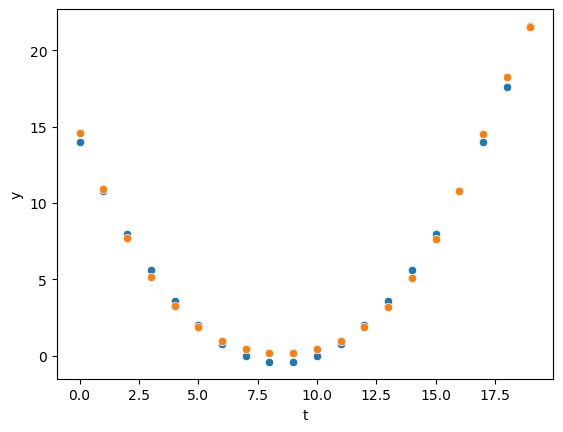

In [15]:
# plot model
k=35
t = traj[k]
df_input = noise_to_rep[n][r]
x0 = df_input['t'].values

y = 10.159414*np.exp(np.cos(0.2574024*x0 + 0.950925547356)) - 3.58521172785722

sns.scatterplot(data=pd.DataFrame.from_dict({'t':df_input['t'].values,'y':df_input[t].values}), x='t', y='y')
sns.scatterplot(data=pd.DataFrame.from_dict({'t':df_input['t'].values,'y':y}), x='t', y='y')

In [17]:
# load sean data
df_sean = pd.read_csv(path + 'inputs/df_sean.tsv',sep='\t',index_col=0)
df_sean = df_sean.set_index('t')
    
# grab current time points
trange = df_sean.index.values
step = 1 
tr = np.arange(np.min(trange), np.max(trange), step)

# create new index
df_input = pd.DataFrame({'t': tr}).set_index('t')

# merge with input df sean
df_input = pd.concat([df_input, df_sean], axis=1)

# interpolate
for c in df_input.columns:
    df_input[c] = df_input[c].interpolate()
    # df_input[c] = df_input[c].interpolate(method='spline', order=2)

df_input = df_input.reset_index()
df_input.head()

,t,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0.0,0.007155,0.009933,0.009331,0.018379,0.006761,0.003677,0.015011,0.014262,0.004050,...,0.007282,0.005100,0.015956,0.024371,0.004004,0.005768,0.006147,0.033674,0.002129,0.015599
1,1.0,0.006183,0.007868,0.007252,0.004856,0.007558,0.015127,0.015866,0.016384,0.019800,...,0.443032,0.421478,0.291868,0.208212,0.214434,0.236917,0.089874,0.075828,0.109843,0.005672
2,2.0,0.007351,0.012866,0.011220,0.013309,0.007260,0.012411,0.070810,0.014767,0.050613,...,0.152731,0.099212,0.440940,0.076807,0.092483,0.533673,0.594490,0.465584,0.494531,0.504454
3,3.0,0.007748,0.011613,0.009226,0.015147,0.005673,0.045168,0.108219,0.025055,0.071747,...,0.136425,0.088072,0.243459,0.051407,0.143225,0.552494,0.473745,0.457868,0.473282,0.497165
4,4.0,0.008144,0.010360,0.007232,0.016985,0.004086,0.077925,0.145627,0.035343,0.092882,...,0.120119,0.076931,0.045978,0.026006,0.193968,0.571315,0.353000,0.450152,0.452032,0.489875


In [18]:
# define list to store models
t_encoded_models = {}
t_models = {}

nsim=1

traj = list(df_input.columns)[1:]
for t in traj:
    models = []
    encoded_models = []
    for i in range(nsim):
        model = PySRRegressor(
            niterations=10,  # < Increase me for better results
            binary_operators=["+", "*"],
            unary_operators=[
                "cos",
                "exp",
                # "sin",
                "inv(x) = 1/x", # Custom operator (julia syntax)
            ],
            # denoise=True,
            extra_sympy_mappings={"inv": lambda x: 1 / x},
            # ^ Define operator for SymPy as well
            # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
            temp_equation_file=True, # to delete temp files
            elementwise_loss="L1DistLoss()",
            # ^ Custom loss function (julia syntax)
        )
        # This will set up the model for 40 iterations of the search code, which contains hundreds of thousands of mutations and equation evaluations.
        
        # Let's train this model on our dataset:
        X = df_input['t'].values
        y = df_input.loc[:,t].values

        df = pd.DataFrame.from_dict({'x':X,'y':y})
        df = df.dropna(how='any',axis=0)
        X = df['x'].values.reshape(-1, 1)
        y = df['y'].values
        model.fit(X, y)
        # Internally, this launches a Julia process which will do a multithreaded search for equations to fit the dataset.
        # Equations will be printed during training, and once you are satisfied, you may quit early by hitting 'q' and then <enter>.
        # After the model has been fit, you can run model.predict(X) to see the predictions on a given dataset using the automatically-selected expression, or, for example, model.predict(X, 3) to see the predictions of the 3rd equation.
        #model.predict(y[3])
        # You may run:
        input_eq = model.sympy()
        encoded_models.append(get_encoding(input_eq))
        models.append(input_eq)
        # print(sympy.simplify(model.sympy()))
    print(models)
    t_models[t] = models
    t_encoded_models[t] = encoded_models
    print(encoded_models)
df = pd.DataFrame.from_dict(data=t_encoded_models)
df.to_csv(path + 'inputs/sean_encoded_models.tsv', sep='\t')

df.head()

[ Info: Started!


[0.0060235094*cos(x0*0.046392404)]
['C*trig(C*x)']


[ Info: Started!


[0.012127933*0.82687324]
['C']


[ Info: Started!


[-0.009952639*cos(exp(0.025635736*x0 + cos(0.15938684)))]
['C*trig(C*e(C*x))']


[ Info: Started!


[cos(x0*0.0024418572*x0)*0.014871216]
['C*trig(C*x^C)']


[ Info: Started!


[0.0835714423010227/(x0 + 11.288581)]
['C/(xoC)']


[ Info: Started!


[(0.41729826*exp(-cos(x0*cos(1.3449903)) - cos(0.7682734)))*cos(cos(0.41729826))]
['C*e(otrig(C*x))']


[ Info: Started!


[1.38535104553049*exp(-2.87058838823742*exp(cos(0.21902896*x0)))]
['C*e(C*e(trig(C*x)))']


[ Info: Started!


[0.074429475*exp(-1.6029981*cos(0.22448415*x0))/cos(-0.51926017)]
['C*e(C*trig(C*x))']


[ Info: Started!


[exp(-1.86933366782406*exp(cos(0.20116939*x0)))]
['e(C*e(trig(C*x)))']


[ Info: Started!


[0.01285517*x0 + 0.018727876*cos(-0.45522028*(x0*cos(-0.22431234) + 0.0035585975))]
['C*xoC*trig(C*xoC)']


[ Info: Started!


[1/(x0 + exp(exp(1/(x0 + cos(exp(x0)) - 0.23997667))))]
['C/(xoe(e(C/(xotrig(e(x))oC))))']


[ Info: Started!


[0.719149321144615/(-0.22208834*x0 + exp(exp(cos(cos(0.23427866*x0)))))]
['C/(C*xoe(e(trig(trig(C*x)))))']


[ Info: Started!


[x0/(exp(x0) + 1/cos(x0)) + 0.066974595]
['x/(e(x)oC/trig(x))oC']


[ Info: Started!


[1/(x0 + exp(exp(cos(1/(x0 + 0.026527997)))))]
['C/(xoe(e(trig(C/(xoC)))))']


[ Info: Started!


[1/(x0 + exp(exp(1/(x0 + x0 - 0.30705112 + 1/cos(x0)))))]
['C/(xoe(e(trig(x)/((C*xoC)*trig(x)oC))))']


[ Info: Started!


[cos(cos(exp(cos(exp(0.23985593*x0*(-0.9296735))))*x0*1.1040229)) - 0.4269377]
['trig(trig(C*x*e(trig(e(C*x)))))oC']


[ Info: Started!


[0.5996832*cos(cos(-0.12848802*x0))]
['C*trig(trig(C*x))']


[ Info: Started!


[0.5776581*cos(-0.10272281*x0 + cos(0.079386145))]
['C*trig(C*xoC)']


[ Info: Started!


[x0/(x0 + x0 + cos(x0*0.32783675))]
['x/(C*xotrig(C*x))']


[ Info: Started!


[cos(-0.38894358 + 1/(x0 + cos(exp(x0))))*0.4866651]
['C*trig(CoC/(xotrig(e(x))))']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,C*trig(C*x),C,C*trig(C*e(C*x)),C*trig(C*x^C),C/(xoC),C*e(otrig(C*x)),C*e(C*e(trig(C*x))),C*e(C*trig(C*x)),e(C*e(trig(C*x))),C*xoC*trig(C*xoC),C/(xoe(e(C/(xotrig(e(x))oC)))),C/(C*xoe(e(trig(trig(C*x))))),x/(e(x)oC/trig(x))oC,C/(xoe(e(trig(C/(xoC))))),C/(xoe(e(trig(x)/((C*xoC)*trig(x)oC)))),trig(trig(C*x*e(trig(e(C*x)))))oC,C*trig(trig(C*x)),C*trig(C*xoC),x/(C*xotrig(C*x)),C*trig(CoC/(xotrig(e(x))))


In [19]:
# create dict of evaluations of sympy obj
t_disc = {}
trajs = list(t_models.keys())
for k in trajs:
    model = t_models[str(k)][0]
    yr = []
    x0 = sympy.symbols('x0')
    xr = tr
    for x in xr: 
        y_value = model.subs(x0, x)
        yr.append(y_value.evalf())
    t_disc[str(k)] = yr

print(t_disc['0'])

[0.00602350940000000, 0.00601702849794437, 0.00599759973783074, 0.00596526492780881, 0.00592009364815905, 0.00586218310156505, 0.00579165790394604, 0.00570866981629977, 0.00561339741813267, 0.00550604572318013, 0.00538684573824376, 0.00525605396609499, 0.00511395185351465, 0.00496084518565634, 0.00479706342803678, 0.00462295901756911, 0.00443890660416479, 0.00424530224453600, 0.00404256254993343, 0.00383112378965333, 0.00361144095224314]


<Axes: xlabel='t', ylabel='y'>

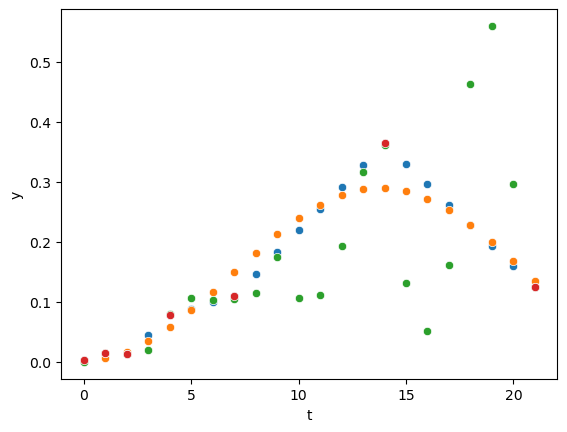

In [21]:
# plot model
k = 5
t = traj[k]
x0 = df_input['t'].values

#y = 0.012955242*np.cos(np.cos(2.33988868042568*np.exp(x0))) #1
y1 = 0.006756823*x0*(np.exp(np.cos(1.3207278*x0 + 0.6175112)) + np.cos(x0) + 1.0573616)
y2 = 0.14569463 + np.cos((x0 + x0)*0.11403156)*(-0.14370494)

# plot the interp data (blue)
sns.scatterplot(data=pd.DataFrame.from_dict({'t':df_input['t'].values,'y':df_input[t].values}), x='t', y='y')
# plot the fitted sympy traj (orange)
sns.scatterplot(data=pd.DataFrame.from_dict({'t':df_input['t'].values,'y':y2}), x='t', y='y')
# plot the fitted sympy traj (green) that is overfitted (fitted on non interp data)
sns.scatterplot(data=pd.DataFrame.from_dict({'t':df_input['t'].values,'y':y1}), x='t', y='y')
# plot original data (red)
sns.scatterplot(data=pd.DataFrame.from_dict({'t':df_sean.index.values,'y':df_sean[t].values}), x='t', y='y')


In [ ]:
# try coherence
# create matrix of coherences
corr_matrix = np.empty([len(trajs),len(trajs)])
corr_matrix[:] = np.nan

for i in range(len(trajs)):
    for j in range(i):
        #f, Cxy = scipy.signal.coherence(t_disc[str(i)], t_disc[str(j)])
        #cm[i,j] = np.real(np.mean(Cxy))
        r, p = scipy.stats.spearmanr(t_disc[str(i)], t_disc[str(j)], nan_policy='omit')
        corr_matrix[i,j] = r
# cm
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix Heatmap')
plt.xticks(range(len(trajs)), trajs, rotation=45)
plt.yticks(range(len(trajs)), trajs)
plt.tight_layout()
plt.show()

In [ ]:
# t_encoded_models
# pd.Series(encoded_models).value_counts()
df = pd.read_csv(path + 'inputs/sean_encoded_models.tsv', sep='\t', index_col=0)

# dict to store mode result
assignment = {}

# get value counts per col and pick top
for t in list(df.columns.values):
    # Count occurrences of each string
    counts = Counter(df.loc[:,t])
    
    # Get the most common string
    assignment[t] = counts.most_common(1)[0][0]

assignment

In [ ]:
batches = [
    [1,2,3,4,5],
    [6,7,8,9],
    [10],
    [11,12,13,14,15],
    [16,17,18,19,20]

]
models = []
for batch in batches:
    model_list = []
    for b in batch:
        model_list.append(assignment[str(b-1)])
    models.append(model_list)

for batch in models:
    print(long_substr(batch))

